In [2]:
# we need the following libraries, so let's install them
%pip install boto3
%pip install torchxrayvision
%pip install SimpleITK
%pip install radiomics
%pip install pyradiomics
%pip install torchvision
%pip install matplotlib
%pip install scikit-learn
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for radiomics: filename=radiomics-0.1-py3-none-any.whl size=6092 sha256=6d2bd80b265785d517b035fb5d9d5c47311c71e617e536b2e175494f85fbc124
  Stored in directory: /root/.cache/pip/wheels/72/f5/9b/32efc9afd085f158d92202cb88e07ddd5793ea549381868b29
Successfully built radiomics
     ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# importing libraries
from time import time
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import skimage
import torch
import SimpleITK as sitk
import skimage, torch, torchvision
import torchxrayvision as xrv
import torchvision
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import sys
import warnings
from sklearn.utils import shuffle
import random
import logging
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=DeprecationWarning)
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# loadnig the data and removing the useless column 'Unnamed: 0'
whole_data = pd.read_csv('/content/gdrive/MyDrive/radiomics/MIMIC_synced_data_nan_free_.csv')
whole_data.head(5)


,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,0,-872.712177,-30.834509,1.183500e+10,5.213223,484.245094,2.123297,127.427505,259.288179,-535.029395,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,-860.588226,-94.596062,1.748392e+10,5.468412,406.884354,2.973349,455.105927,238.126282,-510.922325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,-771.608655,246.313766,1.054451e+10,5.639891,569.798054,2.284384,601.678467,308.126190,-357.526186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,-918.119244,197.538876,1.041507e+10,5.650920,757.435298,1.774919,477.192200,369.400809,-432.636913,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4,-809.137268,336.588287,1.613116e+10,5.824157,562.000023,2.493775,658.329407,330.944854,-337.573971,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [10]:
whole_data.shape

(224444, 492)

In [14]:
whole_data['subject_id']

62087     16337794.0
42852     11581121.0
98533     10632213.0
172173    12764286.0
131165    17029048.0
             ...    
226858    13912733.0
13485     12455543.0
15222     10056223.0
106535    12614428.0
29958     12246903.0
Name: subject_id, Length: 224444, dtype: float64

In [8]:
list(whole_data.iloc[:,464:])

['feature_463',
 'index',
 'path',
 'subject_id',
 'study_id',
 'dicom_id',
 'PerformedProcedureStepDescription',
 'ViewPosition',
 'ProcedureCodeSequence_CodeMeaning',
 'ViewCodeSequence_CodeMeaning',
 'Race',
 'Ethnicity',
 'Sex',
 'Age',
 'No Finding',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Enlarged Cardiomediastinum',
 'Fracture',
 'Lung Lesion',
 'Lung Opacity',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Support Devices']

In [9]:
# excludiung Ages with Nans
whole_data = whole_data[~pd.isnull(whole_data['Age'])]
whole_data.shape

(224444, 492)

In [11]:
random_seed = 21202
del whole_data['Unnamed: 0']
whole_data.head()
whole_data = whole_data.sample(frac=1.0, random_state=random_seed)

In [12]:
# finding total number of samples:
n_samples = whole_data.shape[0]
print("number of samples are: {}".format(n_samples))

number of samples are: 224444


In [13]:
# names of all targets:
targets_names = list(whole_data.iloc[:,464:])
print(targets_names)

['index', 'path', 'subject_id', 'study_id', 'dicom_id', 'PerformedProcedureStepDescription', 'ViewPosition', 'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning', 'Race', 'Ethnicity', 'Sex', 'Age', 'No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']


In [15]:
whole_data['subject_id']

62087     16337794.0
42852     11581121.0
98533     10632213.0
172173    12764286.0
131165    17029048.0
             ...    
226858    13912733.0
13485     12455543.0
15222     10056223.0
106535    12614428.0
29958     12246903.0
Name: subject_id, Length: 224444, dtype: float64

In [16]:
# finding the number of unique subjects:
unique_subjects = pd.unique(whole_data['subject_id'])
print('The number of unique subjects are: {0}'.format(len(unique_subjects)))

The number of unique subjects are: 60429


In [18]:
# preallocating the frequency of session of the subjects:
# this is written to make sure that we dont use a subject in both training and testing split.
test_split = 0.06       # precent out of total samples
valid_split = 0.1       # precent out of total samples (this is the sumation of both training and validation splits)

n_test = n_samples * test_split
n_whole_train = n_samples - n_test

frequencies = np.ones((unique_subjects.shape[0], 4)) * np.nan
for i, sbj in tqdm(enumerate(unique_subjects)):
  frequencies[i, 0] = sbj
  frequencies[i, 1] = (whole_data['subject_id'] == sbj).sum()
cumolative_sums_of_samples = np.cumsum(frequencies[:,1])
frequencies[:, 2] = cumolative_sums_of_samples
frequencies[:, 3] = cumolative_sums_of_samples/cumolative_sums_of_samples[~0]

60429it [00:27, 2213.39it/s]


In [19]:
# visualizing the frequency  of subjects and images taken from each
vis_frequencies = pd.DataFrame(frequencies,columns=['subject_ID','n_of_sessions/images','cumolative_sessions','preccent_of_number_of_images'])
vis_frequencies.head(15)

,subject_ID,n_of_sessions/images,cumolative_sessions,preccent_of_number_of_images
0,16337794.0,52.0,52.0,0.000232
1,11581121.0,4.0,56.0,0.000250
2,10632213.0,1.0,57.0,0.000254
3,12764286.0,7.0,64.0,0.000285
4,17029048.0,1.0,65.0,0.000290
5,12566705.0,3.0,68.0,0.000303
6,16860825.0,22.0,90.0,0.000401
7,13834529.0,5.0,95.0,0.000423
8,19016834.0,27.0,122.0,0.000544
9,15201268.0,2.0,124.0,0.000552


In [20]:
# separating the testing split without having any mutual_subjects:
testing_subjects_masking = vis_frequencies['preccent_of_number_of_images'] < test_split
testing_subjects = vis_frequencies[testing_subjects_masking]['subject_ID'].values.tolist()
whole_train_subjects = vis_frequencies[~testing_subjects_masking]['subject_ID'].values.tolist()

In [21]:
# excluding irrelevant features
excluding2ds =  np.concatenate( (np.arange(32,41,dtype=int),
                                 np.arange(32,41,dtype=int)+ 116,
                                 np.arange(32,41,dtype=int)+116*2,
                                 np.arange(32,41,dtype=int)+116*3))

whole_data.drop(whole_data.columns[excluding2ds.tolist()],axis = 1,inplace=True)


In [22]:
# separating test_data and whole_trainig_data

Test = whole_data[whole_data['subject_id'].isin(testing_subjects)]
X_test, y_test = Test.iloc[:,:464-36].values, Test['Age'].values

# separating test_data and whole_trainig_data
Train = whole_data[whole_data['subject_id'].isin(whole_train_subjects)]

# the size of training/testing_split:
print('The size of the testing split is: {}'.format(Test.shape))
print('The size of the whole trainig (train + valid) split is: {}'.format(Train.shape))

The size of the testing split is: (13409, 455)
The size of the whole trainig (train + valid) split is: (211035, 455)


In [23]:
# splitting the validation split:
X_train, X_val, y_train, y_val = train_test_split(Train.iloc[:,:464-36].values,
                                                  Train['Age'].values,
                                                  test_size=valid_split,
                                                  random_state=random_seed)

In [24]:
# checking the number of nans:
pd.isnull(X_train).sum(), pd.isnull(X_test).sum(), pd.isnull(X_val).sum()

(0, 0, 0)

In [25]:
print('The size of the validation split is: {}'.format(X_val.shape))
X_train.shape, X_val.shape, y_train.shape, y_val.shape

The size of the validation split is: (21104, 428)


((189931, 428), (21104, 428), (189931,), (21104,))

In [26]:
# normalizing the data
mean_val = X_train.mean(axis=0)
std_val = X_train.std(axis=0)


In [27]:
# excluding invariant variables:
mask_excluded = ~(std_val==0)

In [28]:
X_train[:,mask_excluded] -= mean_val[mask_excluded]
X_train[:,mask_excluded] /= std_val[mask_excluded]

X_val[:,mask_excluded] -= mean_val[mask_excluded]
X_val[:,mask_excluded] /= std_val[mask_excluded]

X_test[:,mask_excluded] -= mean_val[mask_excluded]
X_test[:,mask_excluded] /= std_val[mask_excluded]

In [29]:
# saving_path = '/content/gdrive/MyDrive/radiomics/age_chexpert/chexpert_age_full_'
saving_path = '/content/gdrive/MyDrive/radiomics/second_results/mimic_age_full_'
belongings={'mean':mean_val,
            'std':std_val,
            'mask_excluded':mask_excluded,
            'x_test':X_test,
            'y_test':y_test}
np.save(saving_path + 'belongings.npy',belongings)

In [35]:
# defining the model structure for the age
# %% building uncompiled mdodel

checkpoint_filepath = saving_path +'_mdl.h5'
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
                                                                filepath=checkpoint_filepath,
                                                                save_weights_only=False,
                                                                monitor='val_loss',
                                                                save_best_only=True,
                                                                save_freq='epoch',
                                                                verbose=1
                                                            )


def classifer_1(features_number: int) -> callable:
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=200, activation="tanh", input_dim=features_number))
    model.add(keras.layers.Dropout(0.0))
    model.add(keras.layers.Dense(units=200, activation="tanh"))
    model.add(keras.layers.Dropout(0.0))
    model.add(keras.layers.Dense(units=1))
    model.summary()
    return model

def compiler_1(X_train_, Y_train_, X_valid_, Y_valid_):
  initial_learning_rate = 0.0001
  epochs = 500
  batch_size = 512
  model = classifer_1(features_number=X_train_.shape[1])
  # lss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # metrics = ['accuracy',
  #                       tf.keras.metrics.AUC(curve='PR',name='PR-curve'),
  #                       tf.keras.metrics.AUC(curve='ROC',name='ROC-curve')]
  # metrics = metrics=[tf.keras.metrics.RootMeanSquaredError()]
  metrics = [tf.keras.metrics.RootMeanSquaredError()]
  lss = 'mean_absolute_error'
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-08),
                                                loss=lss,
                metrics=metrics)
  model.fit(x=X_train_,
            y=Y_train_,
            epochs=epochs,
            initial_epoch=0,
            batch_size=batch_size,
            validation_data=(X_valid_, Y_valid_),
            verbose=2,
            shuffle=True,
            callbacks=[model_checkpoint_callback_1])
  return model

In [36]:
pd.isnull(y_test).sum()

0

(array([ 54.,   0., 106.,   0.,   0., 112.,   0.,   0., 106.,   0., 125.,
          0.,   0., 135.,   0.,   0., 125.,   0.,   0., 148.,   0., 127.,
          0.,   0., 142.,   0.,   0., 139.,   0.,   0., 130.,   0., 147.,
          0.,   0., 138.,   0.,   0., 161.,   0.,   0., 110.,   0., 126.,
          0.,   0., 151.,   0.,   0., 140.,   0.,   0., 141.,   0., 144.,
          0.,   0., 168.,   0.,   0., 174.,   0.,   0., 185.,   0., 198.,
          0.,   0., 203.,   0.,   0., 220.,   0., 236.,   0.,   0., 275.,
          0.,   0., 285.,   0.,   0., 310.,   0., 288.,   0.,   0., 370.,
          0.,   0., 343.,   0.,   0., 447.,   0., 324.,   0.,   0., 430.,
          0.,   0., 403.,   0.,   0., 396.,   0., 431.,   0.,   0., 459.,
          0.,   0., 464.,   0.,   0., 437.,   0., 473.,   0.,   0., 476.,
          0.,   0., 497.,   0.,   0., 465.,   0., 486.,   0.,   0., 496.,
          0.,   0., 450.,   0., 467.,   0.,   0., 405.,   0.,   0., 410.,
          0.,   0., 451.,   0., 437., 

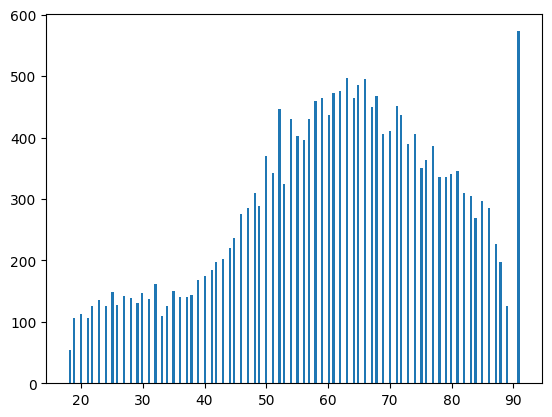

In [37]:
plt.hist(y_val,200)

In [38]:
model_1 = compiler_1(X_train_ = X_train[:,mask_excluded],
                    Y_train_ = y_train,
                    X_valid_ = X_val[:,mask_excluded],
                    Y_valid_ = y_val)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 200)               84200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 124,601
Trainable params: 124,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500

Epoch 1: val_loss improved from inf

KeyboardInterrupt: ignored